In [1]:
import torch
import numpy as np
import auction
import torch.nn as nn
import torch.nn.functional as F
import timeit
import sinkhorn
import matplotlib.pyplot as plt

In [2]:
manual_seed = 137
np.random.seed(seed=manual_seed)
torch.manual_seed(manual_seed)

In [3]:
#distrib = torch.distributions.Exponential(torch.tensor([1.0]))
size_batch = (int)(10**4)
print(size_batch)
K=10
#y = torch.tensor([0.5, 1])
y = torch.linspace(1./K, 1., K) # discretization of uniform distribution
beta= torch.ones(K)/K
print(y)
print(beta)

10000
tensor([0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000, 0.9000,
        1.0000])
tensor([0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
        0.1000])


In [4]:
net = auction.BidderStrategy(size_layer=100, nactions=12)

In [5]:
net.fc2[0].weight

Parameter containing:
tensor([[ 0.0322,  0.0393,  0.0247, -0.0043,  0.0095,  0.0288,  0.0187,  0.0227,
          0.0314,  0.0366,  0.0475,  0.0298,  0.0293,  0.0411,  0.0218,  0.0174,
          0.0216,  0.0311,  0.0271,  0.0248,  0.0185,  0.0242,  0.0218,  0.0037,
          0.0098,  0.0262,  0.0389,  0.0137,  0.0146,  0.0112,  0.0177,  0.0173,
          0.0220,  0.0083,  0.0105,  0.0074,  0.0107,  0.0267,  0.0379,  0.0030,
          0.0195,  0.0181,  0.0116,  0.0363,  0.0185,  0.0237,  0.0260,  0.0227,
          0.0275,  0.0139,  0.0338,  0.0321,  0.0158,  0.0270, -0.0004,  0.0235,
          0.0222,  0.0108,  0.0149,  0.0128,  0.0233,  0.0231,  0.0265,  0.0111,
          0.0272,  0.0038,  0.0161,  0.0217,  0.0172,  0.0242, -0.0038,  0.0364,
          0.0289,  0.0083,  0.0265,  0.0207,  0.0147,  0.0127,  0.0128,  0.0016,
          0.0319,  0.0134,  0.0062,  0.0373,  0.0055,  0.0162,  0.0049,  0.0241,
          0.0162,  0.0127,  0.0193,  0.0299,  0.0282,  0.0106,  0.0318,  0.0240,
      

In [6]:
distrib = torch.distributions.Exponential(torch.tensor(1.))

In [7]:
input = torch.zeros((size_batch, 1),requires_grad=True)
samples = distrib.sample((size_batch, 1))
input.data = samples.clone()
print(input.size())

torch.Size([10000, 1])


In [8]:
time = timeit.default_timer()
C = auction.LazySecondPriceLoss(net, input, y, size_batch, distribution="exponential")
print('done in {0} s'.format(timeit.default_timer()-time))
print(C)

done in 1.1132901899982244 s
tensor([[1.3510, 1.2500, 1.1490, 1.0480, 0.9471, 0.8461, 0.7451, 0.6441, 0.5432,
         0.4422],
        [1.2083, 1.1073, 1.0063, 0.9053, 0.8044, 0.7034, 0.6024, 0.5014, 0.4005,
         0.2995],
        [1.3694, 1.2684, 1.1674, 1.0665, 0.9655, 0.8645, 0.7635, 0.6626, 0.5616,
         0.4606],
        [1.4230, 1.3220, 1.2210, 1.1200, 1.0191, 0.9181, 0.8171, 0.7161, 0.6152,
         0.5142],
        [1.2557, 1.1548, 1.0538, 0.9528, 0.8518, 0.7509, 0.6499, 0.5489, 0.4479,
         0.3470],
        [1.5409, 1.4399, 1.3390, 1.2380, 1.1370, 1.0360, 0.9351, 0.8341, 0.7331,
         0.6321],
        [1.4099, 1.3090, 1.2080, 1.1070, 1.0060, 0.9051, 0.8041, 0.7031, 0.6021,
         0.5012],
        [1.2816, 1.1806, 1.0796, 0.9786, 0.8777, 0.7767, 0.6757, 0.5747, 0.4738,
         0.3728],
        [1.4253, 1.3243, 1.2233, 1.1223, 1.0214, 0.9204, 0.8194, 0.7184, 0.6175,
         0.5165],
        [1.5076, 1.4066, 1.3056, 1.2047, 1.1037, 1.0027, 0.9017, 0.8008, 0.6998,

# Sinkhorn

## Train network

In [9]:
net = auction.BidderStrategy(size_layer=100, nactions=12)
net.projection()
lamb = 0.01
niter_sink = 100
niter = 300
lr = 0.01
batch = 1000

In [10]:
loss_profile = auction.train_sinkhorn_auction(net, y, beta, lamb=lamb, niter_sink=niter_sink, max_iter=niter, 
                                              learning_rate=lr, err_threshold=1e-3, verbose=True, verbose_freq=100, size_batch=batch)

Loss at iterations 100: 0.44831913709640503
Loss at iterations 200: 0.47912973165512085
Loss at iterations 300: 0.4723961055278778
done in 20.63096081399999 s


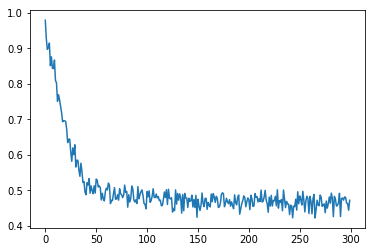

In [11]:
plt.plot(loss_profile)

In [12]:
loss, gamma, C = auction.eval(net, y, beta, lamb=lamb, niter_sink=(int)(1e5), size_batch=100000)

In [13]:
print('True loss:{}'.format(loss))
print('Utility loss:{}'.format(torch.sum(gamma*C)))
alpha = net.alpha()
print('Privacy loss:{}'.format(sinkhorn._KL(alpha, beta, gamma, epsilon=0)))

True loss:0.4649014472961426
Utility loss:0.4649014472961426
Privacy loss:-1.0282176390319364e-06


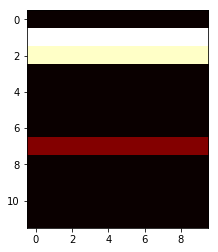

In [14]:
plt.imshow(gamma.detach().numpy(), cmap='hot')
plt.show()

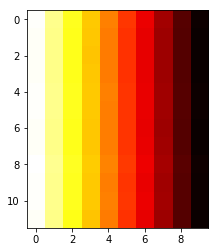

In [15]:
plt.imshow(C.detach().numpy(), cmap='hot')
plt.show()

# Comparing with GPU

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Use device {}'.format(device))
net = auction.BidderStrategy(size_layer=100, nactions=12, device=device)
t = timeit.default_timer()
net.to(device)
print('Exported to {} in {} s'.format(device, timeit.default_timer()-t))

Use device cuda:0
Exported to cuda:0 in 0.0008730709996598307 s


In [15]:
loss_profile = auction.train_sinkhorn_auction(net, y.to(device), beta.to(device), lamb=lamb, niter_sink=niter_sink, max_iter=niter, device=device,
                                              learning_rate=lr, err_threshold=1e-3, verbose=True, verbose_freq=100, size_batch=batch)

Loss at iterations 100: 0.5407759547233582
Loss at iterations 200: 0.49048399925231934
Loss at iterations 300: 0.5052505731582642
Loss at iterations 400: 0.4579058885574341
Loss at iterations 500: 0.4759369492530823
Loss at iterations 600: 0.48087358474731445
Loss at iterations 700: 0.4989890456199646
Loss at iterations 800: 0.4441834092140198
Loss at iterations 900: 0.46767282485961914
Loss at iterations 1000: 0.4851957857608795
done in 38.26735725799972 s


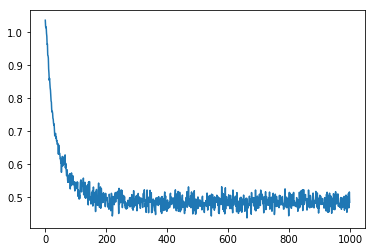

In [16]:
plt.plot(loss_profile)